In [1]:
from rigid_co import *
from without_seg_fun import *
def co_registration(patient_id=None,moving_path_mask=None,target_path_mask=None,moving_path_raw=None,target_path_raw=None,only=False):
    # load original data 
    pre_data = nib.load(target_path_raw).get_fdata()
    post_data = nib.load(moving_path_raw).get_fdata()
    if only:
        #generate random data
        img_data_pre = np.zeros((pre_data.shape[0], pre_data.shape[1], pre_data.shape[-1]), dtype=np.uint8)
        img_data_post = np.zeros((post_data.shape[0], post_data.shape[1], post_data.shape[-1]), dtype=np.uint8)
        for i in range(pre_data.shape[-1]):
            img_data_pre[:, :, i] = draw_two_parallel_lines(np.zeros((pre_data.shape[0], pre_data.shape[0]))) 
        
        for i in range(post_data.shape[-1]):
            img_data_post[:, :, i] = draw_wide_diagonal_line(np.zeros((post_data.shape[0], post_data.shape[0])))
    else:
        # load segmentation data
        img = nib.load(target_path_mask)
        img_data_pre = img.get_fdata() 
        img = nib.load(moving_path_mask)
        img_data_post = img.get_fdata()



    sdf_ct= distance_transform_edt(torch.tensor(img_data_post).permute(2, 0, 1))  
    sdf_oct= distance_transform_edt(torch.tensor(img_data_pre).permute(2, 0, 1))

    CT_sdf_cpr = torch.tensor(sdf_ct).unsqueeze(0)
    OCT_sdf_cpr = torch.tensor(sdf_oct).unsqueeze(0)
    """
    # Plot areas
    plt.figure(figsize=(10, 6))
    """
    Area_CT_ori = torch.sum((CT_sdf_cpr > 0), dim=(0, 2, 3))
    Area_OCT = torch.sum((OCT_sdf_cpr > 0), dim=(0, 2, 3))
   
    # detect bifurcation
    root = tk.Tk()
    root.title("Peaks Matcher GUI")
    app = PeaksMatcherGUI(master=root, Area_CT=Area_CT_ori, Area_OCT=Area_OCT, CT_image=CT_sdf_cpr>0, OCT_image=OCT_sdf_cpr>0,or_ct=torch.tensor(post_data).permute(2, 0, 1).unsqueeze(0),or_oct=torch.tensor(pre_data).permute(2, 0, 1).unsqueeze(0))
    app.mainloop()
    # Capture organized pairs before closing
    #organized_pairs = organize_matched_pairs(app.highlighted_points)
    organized_pairs,ang_big,an = organize_matched_pairss(app.saving_orientation,app.saving_orientation_angl_show)
    print("Last organized pairs:", organized_pairs)

    left_count = sum(1 for item in an if item[1] == 'left')
    right_count = sum(1 for item in an if item[1] == 'right')
    an = np.array(an)
    
    if left_count>=right_count:
        print("The orientation is left")
        print(left_count)
        z = [float(x[0])* math.pi/180 for x in an] 
        z = [-abs(value) for value in z]
        right_indices = [i for i, item in enumerate(an) if item[1] == 'right']
        for i in right_indices:
            z[i] = -6.28-z[i]
    else:
        print(right_count)
        z = [float(x[0])* math.pi/180 for x in an]
        left_indices = [i for i, item in enumerate(an) if item[1] == 'left'] 
        for i in left_indices:
            z[i] = 6.28-z[i]

    #z = [float(x[0])* math.pi/180 for x in an]
    #left_indices = [i for i, item in enumerate(an) if item[1] == 'left'] 
    #for i in left_indices:
    #    z[i] = -z[i]

    ang_big = z
    print("Anglel",ang_big)


    CT_selected_indices = torch.tensor([t[0] for t in organized_pairs])
    OCT_selected_indices = torch.tensor([t[1] for t in organized_pairs])
    idx_OCT_shift = OCT_selected_indices[0]
    idx_CT_shift = CT_selected_indices[0]

    # indices following shift based on first bifurcation
    OCT_selected_indices_shift = OCT_selected_indices - idx_OCT_shift
    print('OCT_selected_indices_shift:must start with 0', OCT_selected_indices_shift)
    CT_selected_indices_shift = CT_selected_indices - idx_CT_shift
    print('CT_selected_indices_shift:must start with 0', CT_selected_indices_shift)
    CT_sdf_cpr = CT_sdf_cpr[:,CT_selected_indices[0]:,...]
    OCT_sdf_cpr = OCT_sdf_cpr[:,OCT_selected_indices[0]:,...]

    # cat same length
    if CT_sdf_cpr.shape[1] < OCT_sdf_cpr.shape[1]:
        OCT_sdf_cpr = OCT_sdf_cpr[:, :CT_sdf_cpr.shape[1], ...]
    else:
        CT_sdf_cpr = CT_sdf_cpr[:, :OCT_sdf_cpr.shape[1], ...]
    #angl of bifurcation
    #RULES
    # 1. Moving image is CT refernce to target OCT
    # 2. Clockwise is negative, counter clockwise is positive
    # 3. Maintain the same SIGN orientation of the moving image for ALL bifurcations (ALL positive or ALL negative)
    # 4. Maximum angle is 180 degrees or 3.14 radians
    print('ang_for each bifurcation:',ang_big)
    angl  = ang_big
    theta_shift = angl


    t = torch.linspace(0, 1,CT_sdf_cpr.shape[1])
    vector = torch.full((CT_sdf_cpr.shape[1],1), float('nan'))

    for i,b in zip(CT_selected_indices_shift,torch.tensor(theta_shift)):
        vector[i] = b
    # parametrized spline
    coeffs = natural_cubic_spline_coeffs(t, vector)
    splines = NaturalCubicSpline(coeffs)
    theta_vec_cubic = splines.evaluate(t)
    mask = ~np.isnan(vector.numpy()).flatten()
    t_clean = t.numpy()[mask]
    vector_clean = vector.numpy()[mask].flatten()
    pchip = PchipInterpolator(t_clean, vector_clean)
    # add end point by cubic spline
    arr = pchip(t)  # Get the array
    arr[CT_selected_indices_shift[-1]:] = theta_vec_cubic[CT_selected_indices_shift[-1]:].reshape(-1)  # Modify the slice  

    #plt.scatter(CT_selected_indices_shift, angl, label='Original', color='red')
    #plt.plot(pchip(t)[:410], label='Pchip', color='orange')
    #plt.plot(theta_vec_cubic, label='Cubic', color='green')
    #plt.plot(arr, label='Final', color='blue')
    #plt.legend()
    ct_data_or  = torch.tensor(post_data[:,:,idx_CT_shift:CT_sdf_cpr.shape[1]+idx_CT_shift]).permute(2, 0, 1).unsqueeze(0)
    oct_data_or = torch.tensor(pre_data[:,:,idx_OCT_shift:OCT_sdf_cpr.shape[1]+idx_OCT_shift]).permute(2, 0, 1).unsqueeze(0)

    ph_or = ridgit_register(ct_data_or[0], torch.tensor(np.array(arr).reshape(-1,1)))
    ph = ridgit_register(CT_sdf_cpr[0], torch.tensor(np.array(arr).reshape(-1,1)))
    if only:
        oct_circl = detect_center(pre_data)
        ct_circl = detect_center(post_data)
    else:
        ct_circl = []
        for i in range(CT_sdf_cpr.shape[1]):
            orientation,centroid = center_circle(ph.unsqueeze(0)[0,i,...].detach().numpy()>0)
            ct_circl.append(centroid)

        oct_circl= []
        for i in range(OCT_sdf_cpr.shape[1]):
            orientation,centroid = center_circle(OCT_sdf_cpr[0,i,...].detach().numpy()>0)
            oct_circl.append(centroid)

        # Convert centers to numpy arrays for easier processing
        oct_circl = np.array([c for c in oct_circl if c[0] is not None and c[1] is not None])
        ct_circl = np.array([c for c in ct_circl if c[0] is not None and c[1] is not None])
   
        # Ensure there are enough points to apply the filter
        if len(oct_circl) > 31 and len(ct_circl) > 31:
            # Smooth the center coordinates
            oct_circl = np.copy(oct_circl)
            ct_circl = np.copy(ct_circl)
            
            for dim in range(2):  # For both x and y dimensions
                oct_circl[:, dim] = savgol_filter(oct_circl[:, dim], 31, 2)
                oct_circl[:, dim] = savgol_filter(ct_circl[:, dim], 31, 2)
   
    ph_or_circle = rotation(ph_or.unsqueeze(0),oct_circl,ct_circl)
    #ph_or_smooth_min = rotation(ph_or.unsqueeze(0),OCT_centers_smoothedmin,CT_centers_smoothedmin)
    #ph_translation_smooth_min = rotation(ph.unsqueeze(0),OCT_centers_smoothedmin,CT_centers_smoothedmin)
    ph_circle = rotation(ph.unsqueeze(0),oct_circl,ct_circl)



    patient = patient_id
    #d = torch.load('data_dict_bif_angl.pt')
    d = {}
    d[patient] = {}
    ############################ PRE-FINAL ############################

    d[patient]['bif_(PostTarget_StentMoving)'] = [organized_pairs,ang_big]
    d[patient]['bif_(PostTarget_StentMoving)'][0]
    # substract first tuple from all tuples in the list
    l = [(x[0]-d[patient]['bif_(PostTarget_StentMoving)'][0][0][0], x[1]-d[patient]['bif_(PostTarget_StentMoving)'][0][0][1]) for x in d[patient]['bif_(PostTarget_StentMoving)'][0]]
    fixed_image = oct_data_or.detach().numpy().squeeze().transpose(1, 2, 0)
    moving_image = np.array(ph_or_circle).transpose(1, 2, 0)

    bil = []
    for i in range(len(l)-1):
        
        lengthf = fixed_image[:,:,l[i][1]:(l[i+1][1])].shape[-1]
        lengthm = moving_image[:,:,l[i][0]:(l[i+1][0])].shape[-1]

        frames = moving_image[:,:,l[i][0]:(l[i+1][0])]
        print(lengthf-lengthm)
        if (lengthf-lengthm)>0 and (l[i+1][1]-l[i][1])>5:
            print('duplicate')
            num_duplicates = lengthf - lengthm 
            sq = duplicate_frames(frames, num_duplicates=num_duplicates, exclusion_fraction=0.2)
            bil.append(sq)
        if (lengthf-lengthm)<0 and (l[i+1][1]-l[i][1])>5:
            print('remove')
            num_removals = lengthm - lengthf 
            sq = remove_frames(frames, num_removals=num_removals, exclusion_fraction=0.2)
            bil.append(sq)

        if (lengthf-lengthm)==0 or (l[i+1][1]-l[i][1])<=5:
            print('normal')
            bil.append(frames)
    bil.append(moving_image[:,:,l[-1][0]:])
    br = np.concatenate((bil),axis=2)
    print(OCT_selected_indices_shift)
    return CT_selected_indices_shift, OCT_selected_indices_shift, fixed_image, br, organized_pairs,ang_big,ct_data_or 



In [2]:
patient = '706006'
patient_id = '706006'
moving_path_mask=patient_id+'Final.nii.gz'
target_path_mask=patient_id+'Pre.nii.gz'
moving_path_raw=patient_id+'Final_0000.nii.gz'
target_path_raw=patient_id+'Pre_0000.nii.gz'
CT_selected_indices_shift,OCT_selected_indices_shift, fixed_image, br,organized_pairs,ang_big,ct_data_or  =co_registration(patient,moving_path_raw=moving_path_raw,target_path_raw=target_path_raw,only=True)

Creating widgets...
[]
update oct frame
update oct frame
update oct frame
update ct frame
update ct frame
update ct frame
update ct frame
update ct frame
update ct frame
update ct frame
update oct frame
update oct frame
update oct frame
update oct frame
update oct frame
update oct frame
update oct frame
update oct frame
update oct frame
update oct frame
update oct frame
update oct frame
update oct frame
update oct frame
update oct frame
update oct frame
update oct frame
update oct frame
update oct frame
update oct frame
update oct frame
update oct frame
update oct frame
update oct frame
update oct frame
update oct frame
update oct frame
update oct frame
update oct frame
update oct frame
update oct frame
update oct frame
update oct frame
update oct frame
update oct frame
update oct frame
update oct frame
update oct frame
update oct frame
update oct frame
update oct frame
update oct frame
update oct frame
update oct frame
update oct frame
update oct frame
update oct frame
update oct fram

: 

In [15]:
def show_images(i):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    axs[0].imshow(fixed_image[...,i])
    axs[0].set_title('Target(Pre)')

    axs[1].imshow(br[:,:,i])
    axs[1].set_title('Resample random removel\duplicate')
    axs[2].imshow(ct_data_or[0,i,...])
    axs[2].set_title('Moving')
    plt.show()

# Interactive slider
frame_slider = IntSlider(min=0, max=fixed_image.shape[1]-1, step=1, value=0)
interact(show_images, i=frame_slider)
OCT_selected_indices_shift


<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
/var/folders/pq/565ymkrj7bxb6b5dgpkmf4mm0000gn/T/ipykernel_7022/1011157022.py:8: SyntaxWarning: invalid escape sequence '\d'
  axs[1].set_title('Resample random removel\duplicate')


interactive(children=(IntSlider(value=0, description='i', max=499), Output()), _dom_classes=('widget-interact'…

tensor([  0, 145])

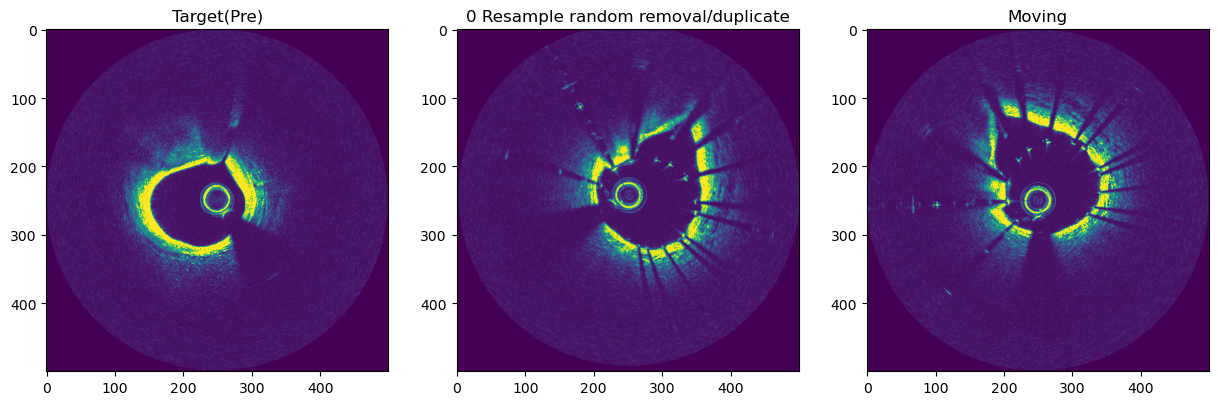

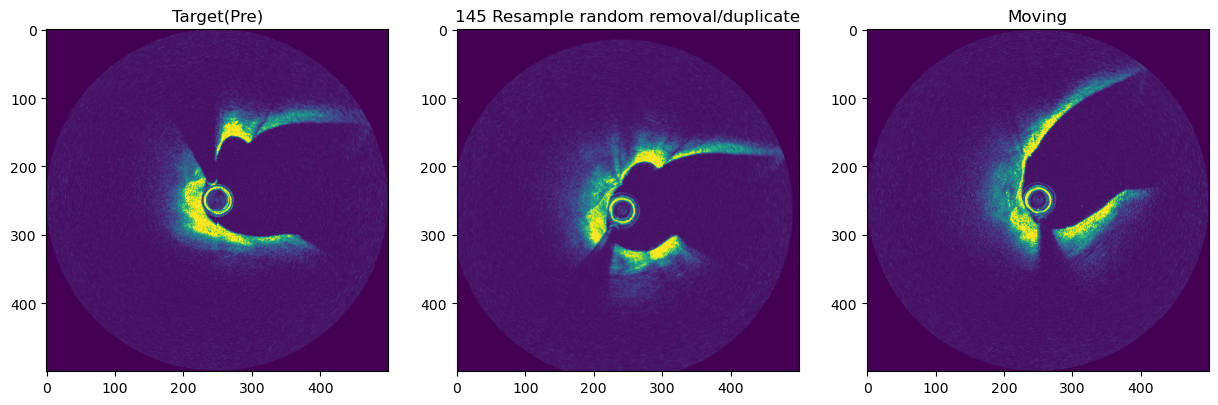

In [16]:
def show_images():
    for index in OCT_selected_indices_shift:
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        
        axs[0].imshow(fixed_image[...,index])
        axs[0].set_title('Target(Pre)')

        axs[1].imshow(br[:,:,index])
        axs[1].set_title(f'{index} Resample random removal/duplicate')

        axs[2].imshow(ct_data_or[0,index,...])
        axs[2].set_title('Moving')
        
        plt.show()

# Call the function to display images
show_images()

In [ ]:
print(f'shape br{br.shape},shape fix{fixed_image.shape}')

In [ ]:
ang_big

In [ ]:
d = torch.load('data_dict_bif_angl.pt')
d[patient] = {}
d[patient]['bif_(PostTarget_StentMoving)'] = [organized_pairs,ang_big]
torch.save(d, 'data_dict_bif_angl.pt')

In [ ]:
#br.shape[-1]
brs = nib.Nifti1Image(br, np.eye(4))
nib.save(brs, patient+'Final_reg_post.nii.gz')

fixed_images = nib.Nifti1Image(fixed_image[:,:,:br.shape[-1]], np.eye(4))       
nib.save(fixed_images, patient+'Post_target_Final.nii.gz')



In [ ]:
img = nib.load(patient+'Post_target_Final.nii.gz')
plt.imshow(img.get_fdata()[:,:,0], cmap='gray')

In [ ]:
img = nib.load(patient+'Final_reg_post.nii.gz')
plt.imshow(img.get_fdata()[:,:,0], cmap='gray')

In [ ]:
def show_images():
    for index in OCT_selected_indices_shift:
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        
        axs[0].imshow(fixed_image[...,index])
        axs[0].set_title('Target(Pre)')

        axs[1].imshow(br[:,:,index])
        axs[1].set_title(f'{index} Resample random removal/duplicate')

        axs[2].imshow(ct_data_or[0,index,...])
        axs[2].set_title('Moving')
        
        plt.show()

# Call the function to display images
show_images()

In [ ]:
d = torch.load('data_dict_bif_angl.pt')

In [ ]:
d[patient] = {}

In [ ]:
d[patient]['bif_(PostTarget_StentMoving)'] = [organized_pairs,ang_big]

In [ ]:
d[patient]

In [ ]:
torch.save(d, 'data_dict_bif_angl.pt')